In [5]:
import numpy as np
import os
import glob 
from PIL import Image

In [217]:
from tqdm import tqdm
import tqdm.notebook as tq

In [137]:
import  matplotlib.pyplot as plt 

In [6]:
PATH = "./Lab2_data/"
test_image = {i.split(".")[0] : np.array(Image.open(PATH + i)) for i in os.listdir(PATH)}

In [201]:
'''Block for functions that will be calculate phi,c,k_* '''
def baseSetUp(img,alpha,N):
    '''
    Return array for :
    - alpha convexity koef
    - number of neigb
    - phi [w*h,N,2] filled by zeros
    - g [2,2] binary loss function 0[g = g_] else -1 
    Return [g,phi]
    '''
    phi = np.zeros((img.shape[0] * img.shape[1],N,2))
    g = np.zeros((2,2))
    g[0][1],g[1][0] = -1,-1#-1
    g = alpha * g
    return phi,g

def evalQ(img,chanel1,chanel2):
    h = img.shape[0]
    w = img.shape[1]
    green_ch = img[:,:,chanel1].ravel()
    blue_ch = img[:,:,chanel2].ravel()
    output = np.zeros([w*h,2])
    for i, t in enumerate(green_ch):
        for k  in range(2): 
            if t > blue_ch[i]:
                output[i][k] = -int(1 != k)
            elif t < blue_ch[i]:
                output[i][k] = -int(0 != k)
            else :
                output[i][k] = 0
    return output


def neigb(t,w,h):
    '''return indexs of t neib  '''
    if t == 0: # first row / first column 
        t = [t + 1,  w - 1 , w*h - w + t, t + w]
        #return t 
    elif t == w - 1 : # first row / last column 
        t = [t - w + 1, t - 1, w*h - w + t, t + w]
        #return t
    elif  t  == w * h  - w : # last row / first column 
        t = [t + 1, t + w - 1, t - w, 0]
        #return t
    elif t == w*h -1 : # last row / last column 
        t = [t - w + 1, t - 1, t - w, w - 1]
        #return t
    elif t < w and t != 0: # first row 
        t = [t + 1, t - 1, w*h - w + t, t + w]
        #return t 
    elif (t + 1) % w == 0 and t != 0: #last column
        t = [t - w + 1, t - 1, t - w, t + w]
        #return t
    elif t % w == 0: # first column 
        t = [t + 1, t + w - 1, t - w, t + w]
        #return t 
    elif t > w * h - w: #last row
        t = [t + 1, t - 1, t - w, w - (w*h - t)]
        #return t 
    else:
        t = [t + 1,t - 1, t - w, t + w]
        #return t
    s = [t[0],t[1],t[2],t[3]] = [t[2],t[3],t[1],t[0]]
    return (s)#t(s)
             
def evalK(t,g,phi,t_neigb): 
    best = {}
    best['K0'] = []
    best['K1'] = []
    for i in range(len(t_neigb)):
        k0 = g[0][0] - phi[t][i][0] - phi[t_neigb[i]][_inverse_direction_dict[i]][0]
        k1 = g[0][1] - phi[t][i][1] - phi[t_neigb[i]][_inverse_direction_dict[i]][1]
        if k1 > k0:
            best['K0'].append([t_neigb[i],1])
        else :
            best['K0'].append([t_neigb[i],0])
    for i in range(len(t_neigb)):
        k0 = g[1][0] - phi[t][i][0] - phi[t_neigb[i]][_inverse_direction_dict[i]][0]
        k1 = g[1][1] - phi[t][i][1] - phi[t_neigb[i]][_inverse_direction_dict[i]][1]
        if k1 > k0:
            best['K1'].append([t_neigb[i],1])
        else :
            best['K1'].append([t_neigb[i],0])
            
    return best
#k_t,k_z,g,
def evalC(t,k,k_flag,phi,q,n):#change 
    pool = []
    poolG = 0
    poolPhi = 0
    
    #q_ = q(k_flag,t)
    q_ = q[t][k_flag]
    for i in range(n):
        if k_flag == 0:
            t_ = k['K0'][i][0]
            poolG += g[k_flag][k['K0'][i][1]] 
            poolPhi += phi[t_][_inverse_direction_dict[i]][k['K0'][i][1]]
        if k_flag == 1:
            t_ = k['K1'][i][0]
            poolG += g[k_flag][k['K1'][i][1]] 
            poolPhi += phi[t_][_inverse_direction_dict[i]][k['K1'][i][1]]
    return (poolG - sum([poolPhi,q_]))/n #len(bestK)

#i,t_,t,g,k_t,k_z,
def updatePhi(t,k,k_flag,phi,c):
    if k_flag == 0:
        for s,[t_,k_i] in enumerate(k['K0']): 
            phi[t][s][0] = g[k_flag][k_i] - phi[t_][_inverse_direction_dict[s]][k_i] - c
            #print(phi[t][k_i][1])
    if k_flag == 1:
       # for t_,k_i in k['K1']: 
            #phi[t][s][1] = g[k_flag][k['K1'][k_i][1]] - phi[t_][_inverse_direction_dict[k_i]][k['K1'][k_i][1]] - c
            #print(phi[t][k_i][1])'''
        for s,[t_,k_i] in enumerate(k['K1']): 
            phi[t][s][1] = g[k_flag][k_i] - phi[t_][_inverse_direction_dict[s]][k_i] - c
            #print(phi[t][k_i][1])

def output(phi,g,px,w,h):
    output = np.zeros([w*h])
    for t in range(len(phi)):
        bestK = []
        t_neigb = neigb(t,w,h)
        for i in range(4):
            k0_0 = g[0][0] - phi[t][i][0] - phi[t_neigb[i]][_inverse_direction_dict[i]][0]
            k0_1 = g[0][1] - phi[t][i][1] - phi[t_neigb[i]][_inverse_direction_dict[i]][1]
            k1_0 = g[1][0] - phi[t][i][0] - phi[t_neigb[i]][_inverse_direction_dict[i]][0]
            k1_1 = g[1][1] - phi[t][i][1] - phi[t_neigb[i]][_inverse_direction_dict[i]][1]
            if max(k0_0,k0_1) > max(k1_0,k1_1):
                #maxK0.append([0,max(k0_0,k0_1)])
                bestK.append(0)
            else :
                 #maxK1.append([1,max(k01_0,k1_1)])
                bestK.append(1)
        if sum(bestK) >= px:
            output[t] = 1
        else :
            output[t] = 0
    return output.reshape(h,w)
        
    
def diffusion(img,N,alpha,q,epoch,px):
    h = img.shape[0]
    w = img.shape[1]
    phi,g = baseSetUp(img,alpha,N)
    #q = evalQ(image)
    for s in range(epoch):
        for i in tq.tqdm(range(w*h)):
            t_neigb = neigb(i,w,h)
            bestK = evalK(i,g,phi,t_neigb)
            for j in range(2):  
                C = evalC(i,bestK,j,phi,q,N)
                updatePhi(i,bestK,j,phi,C)
    return output(phi,g,px,w,h)

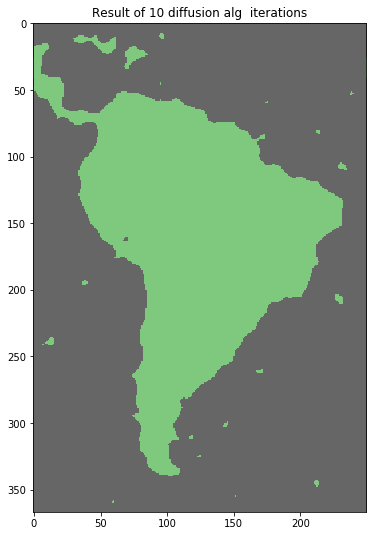

In [221]:
image = test_image['map_hsv']

Neib_Structure = 4
Alpha = 1
N_epoch = 10
Neib_px = 1
Q = (evalQ(image,1,2))
     
img = diffusion(image,Neib_Structure,Alpha,Q,N_epoch,Neib_px)

plt.figure(figsize = (16,9))
plt.title(f"Result of {N_epoch} diffusion alg  iterations");
plt.imshow(img,cmap = 'Accent')
plt.show()

In [ ]:
image = test_image['ipt']

Neib_Structure = 4
Alpha = 1.25
N_epoch = 3
Neib_px = 1

Q = (evalQ(image,1,0))
     
img = diffusion(image,Neib_Structure,Alpha,Q,N_epoch,Neib_px)



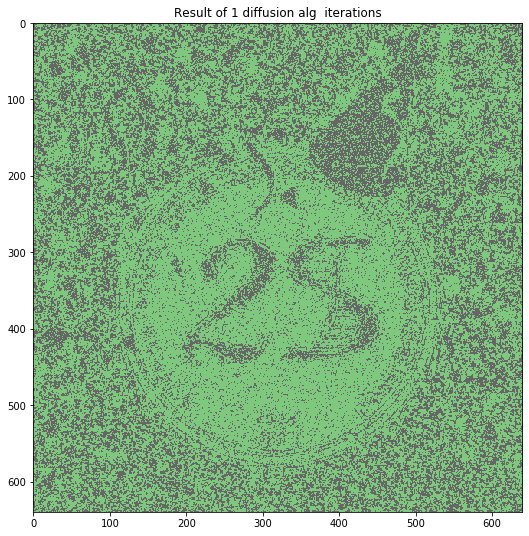

In [226]:
plt.figure(figsize = (16,9))
plt.title(f"Result of {N_epoch} diffusion alg  iterations");
plt.imshow(img,cmap = 'Accent')
plt.show()